# **Taking FastAI to Production**
### A short guide to deploy FastAI model on Nvidia Trition Server

## What is FastAI?

FastAI was released with a very funny tag line __*"Making neural nets uncool again"*__. It offers a high-level API to PyTorch. FastAI and the accompanying course taught by Jeremy Howard and Rachel Thomas have a practical approach to deep learning. It encourages students to train DL models from the first minute. But don't get me wrong FastAI has implemented some of the most brilliant techniques for training the Neural Network effectively and has inspired the development of frameworks such as Pytorch, Tensorflow, Pytorch Lightning, etc. FastAI is a great tool to get you up and running with model training in a (VERY) short time. It has everything you need to get top-notch results with minimal effort in a practical manner.

Source: [Link]("https://www.fast.ai/")

## What is Nvidia Triton?

Triton Inference Server provides a cloud and edge inferencing solution optimized for both CPUs and GPUs. Triton supports an HTTP/REST and GRPC protocol that allows remote clients to request inferencing for any model being managed by the server. For edge deployments, Triton is available as a shared library with a C API that allows the full functionality of Triton to be included directly in an application.

I would like to recommend this awesome blog [Deploying Deep Learning Models with Model Server](https://wobotintelligence-my.sharepoint.com/:w:/g/personal/animikh_wobot_ai/EccXEf5pTDBAi0UxJUjNDBYBQA8cDlECc1aKOazaQJLocQ?e=4%3A6i3PrQ&at=9) by Animikh Aich, if you want to build a great intuitive understanding of Triton Server.

Triton supports the following models for the deployment:
* [TensorRT Models](https://developer.nvidia.com/tensorrt)
* [ONNX Models](https://github.com/onnx/onnx/blob/master/docs/IR.md)
* [TorchScript Models](https://pytorch.org/docs/stable/jit.html)
* [TensorFlow Models](https://www.tensorflow.org/api_docs/python/tf/keras/Model)
* [OpenVINO Models](https://docs.openvino.ai/latest/index.html)
* [DALI Models](https://docs.nvidia.com/deeplearning/dali/user-guide/docs/)

Source: [Link](https://github.com/triton-inference-server/server/blob/main/docs/model_repository.md)

We will be learning about the deployment of the ONNX model in this blog. 

## What is ONNX?

Open Neural Network Exchange or ONNX is a unified format for deep learning and traditional machine learning models. The idea behind ONNX is to create a common interface for all ML frameworks and increase the interoperability between frameworks and devices.

Source: [Link](https://github.com/onnx/onnx/blob/master/docs/IR.md)

![image.png](images/onnx_1.png)

## Why use ONNX and ONNX Runtime?

ONNX, and its implementation - ONNX Runtime, make it easier to put your models into production. You can train your models using the framework of your choice and deploy them to a target that uses ONNX Runtime. This way bloated environments with a large number of dependencies can be minimized to (pretty much) only the ONNX Runtime.

``` opt/miniconda3/envs du -sh test-env-* | sort -h```

```# Returns ```

```# 145M	test-env-onnxruntime```

```# 646M	test-env-pytorch```

```# 1.1G	test-env-fastai```

Source: [Link](https://gist.github.com/tkeyo/4a5c540dda46a40e1cb9b61fdb2aacd6#file-env_size-sh)

Couple of reasons for using ONNX:
* Faster inference
* Lower number of dependencies
* Smaller environment size(Important for serverless deployments)
* One, universal target framework for deployment

## Converting a FastAI model into an ONNX model

FastAI currently doesn't natively support ONNX exports from FastAI learners. But by design FastAI is a high-level API of PyTorch. This allows us to extract the wrapped PyTorch model.PyTorch models can be natively exported to ONNX. So this is gonna be a 2 step process:

![image.png](images/convert.png)

Source: 
* [Link](https://github.com/tkeyo/fastai-onnx/blob/main/fastai_to_onnx.ipynb)
* [Link](https://dev.to/tkeyo/export-fastai-resnet-models-to-onnx-2gj7?signin=true)

## Let's Begin by training a simple model in FastAI

We will be training a simple Cat vs Dog classifier using FastAI

Source: [Link](https://github.com/fastai/fastbook/blob/master/01_intro.ipynb)

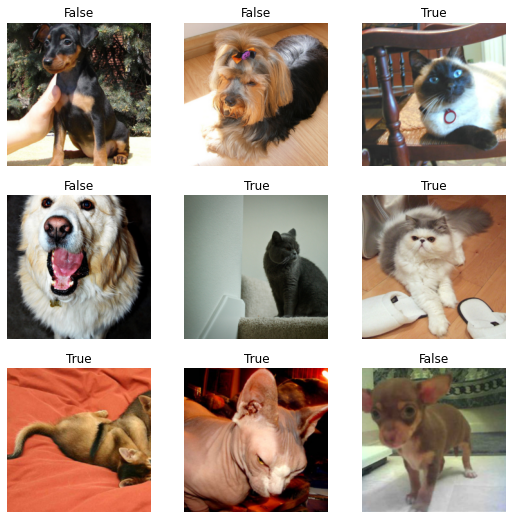

In [1]:
from fastai.vision.all import *
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

path = untar_data(URLs.PETS)/'images'

def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, get_image_files(path), valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(224))

dls.show_batch()

In [7]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.151609,0.027600,0.010149,00:21


epoch,train_loss,valid_loss,error_rate,time
0,0.049710,0.028348,0.008119,00:13
1,0.037441,0.016233,0.005413,00:13
2,0.024642,0.009852,0.002706,00:13


__Voilà!!__ We trained a Cat vs Dog classifier with a remarkable accuracy using FastAI in just 12 lines of code. This is the beauty of FastAI.

In [15]:
# export FastAI learner
learn.export('model.pkl')

In [2]:
# load FastAI learner
learn = load_learner('model.pkl')

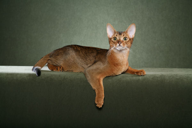

In [3]:
img = PILImage.create('test_images/Abyssinian_1.jpg')
img.to_thumb(192)

## Inference with FastAI learner

In [4]:
print(learn.predict('test_images/Abyssinian_1.jpg'))

('True', tensor(1), tensor([6.1881e-08, 1.0000e+00]))


### __Let us perform our 1st step and get the Pytorch Model from FastAI Learner__. 

But before doing there is one thing we need to know. FastAI wraps the PyTorch model with an additional layer for convenience - **Softmax, Normalization, and other transformation(defined in FastAI DataBlock API)**. When using the native PyTorch model we have to make up for this. Otherwise, we'll be getting weird results.

To get the PyTorch model from the FastAI wrapper we use ```model``` attribute on ```learner```, since we won't be training our model in the next steps we will be setting it to evaluation mode with ```eval()```. 

__Normalization__

First we need to add a normalization layer. Pre-trained PyTorch models are trained on the ImageNet dataset for which the following normalization variables are suggested ___mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]___

Source: [Link](https://pytorch.org/vision/stable/models.html). Normalization is ought to increase model performance.

__Softmax Layer__

By adding a softmax layer at the end of our final model definition we are making our results human-readable.

In [5]:
import torch
import torchvision
import torchvision.transforms as transforms

# https://pytorch.org/vision/stable/models.html

pytorch_model = learn.model.eval() # gets the PyTorch model
softmax_layer = torch.nn.Softmax(dim=1) # define softmax
normalization_layer = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # normalization layer

# assembling the final model
final_model = nn.Sequential(
    normalization_layer,
    pytorch_model,
    softmax_layer
)

This final model will be used for ONNX conversion. FastAI learner also handles resizing but for PyTorch and ONNX this will be handled outside of the model by an extra function.

## Exporting PyTorch model to ONNX

![image.png](images/convert2.png)

Pytorch has native support for ONNX, which means we can directly convert a Pytorch model in ONNX format and then can run it with ONNX Runtime.

__*Note: It is important to call torch_model.eval() or torch_model.train(False) before exporting the model, to turn the model to inference mode. This is required since operators like dropout or batch norm behave differently in inference and training mode.*__

To export a model, we call the ```torch.onnx.export()``` function. This will execute the model, recording a trace of what operators are used to computing the outputs. Because ```export``` runs the model, we need to provide an input tensor ```x```. The values in this can be random as long as it is the right type and size. Note that the input size will be fixed in the exported ONNX graph for all the input dimensions, unless specified as a ```dynamic axes```. In this example, we export the model with an input of batch_size 1, but then specify the first dimension as dynamic in the ```dynamic_axes``` parameter in ```torch.onnx.export()```. The exported model will thus accept inputs of size [batch_size, 3, 224, 224] where batch_size can be variable.

More info : [Pytorch Offical Docs](https://pytorch.org/docs/stable/onnx.html)

In [6]:
torch.onnx.export(
    final_model, 
    torch.randn(1, 3, 224, 224),
    'model.onnx',
    do_constant_folding=True,
    export_params=True,
    input_names=['input'],
    output_names=['output'],
    opset_version=13,
    dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                 'output' : {0 : 'batch_size'}}
)

## Inference with ONNX Runtime

First, we will be creating a function to mimic the transformation pipeline of FastAI's ```predict``` method.

In [7]:
from PIL import Image

def image_transform_onnx(path: str, size: int) -> np.ndarray:
    '''Image transform helper for onnx runtime inference.'''

    image = Image.open(path)
    image = image.resize((size,size))

    # now our image is represented by 3 layers - Red, Green, Blue
    # each layer has a 224 x 224 values representing
    image = np.array(image)

    # dummy input for the model at export - torch.randn(1, 3, 224, 224)
    image = image.transpose(2,0,1).astype(np.float32)

    # our image is currently represented by values ranging between 0-255
    # we need to convert these values to 0.0-1.0 - those are the values that are expected by our model
    image /= 255
    image = image[None, ...]
    return image

In [11]:
import numpy as np
import onnxruntime as rt

labels = ['Dog', 'Cat']

# get image as tensor - 1 x 3 x 256 x 256 dimensions
img = image_transform_onnx('test_images/Abyssinian_1.jpg', 224)

# initialize onnx runtime inference session
sess = rt.InferenceSession('model.onnx')

# input & output names
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name

# input dimensions (important for debugging)
input_dims = sess.get_inputs()[0].shape

print(f"Input layer name: {input_name}, Output layer name: {output_name}, Input Dimension: {input_dims}")

results = sess.run([output_name], {input_name: img})[0]
print(f"It's a {labels[np.argmax(results)]}", results)

Input layer name: input, Output layer name: output, Input Dimension: ['batch_size', 3, 224, 224]
It's a Cat [[5.023443e-07 9.999995e-01]]


## Deploying an ONNX model on Nvidia Triton Server

As we have our ONNX model ready, we will now be deploying it on Nvidia Triton Server.

![image.png](images/triton.png)

Recommended read: [Deploying Deep Learning Models with Model Server](https://wobotintelligence-my.sharepoint.com/:w:/g/personal/animikh_wobot_ai/EccXEf5pTDBAi0UxJUjNDBYBQA8cDlECc1aKOazaQJLocQ?e=4%3A6i3PrQ&at=9)

* Create a directory structure like this. The detailed instructions can be found in the official [readme](https://github.com/triton-inference-server/server/blob/main/docs/model_repository.md) provided by Nvidia:

    ![image.png](images/tree.png)
* Pull the required Triton Server Docker image and run the container, from your ```models``` directory using the following command:

    ```docker run --gpus=all --rm -it -p 8000-8002:8000-8002 --name triton_server -v $PWD:/models nvcr.io/nvidia/tritonserver:21.02-py3 tritonserver --model-repository=/models --strict-model-config=false```
   
* Verify if your model is loaded properly or not. Once the model is loaded successfully, you should see the same printed in the docker logs and the status for the given model should be “READY”.

    ![image.png](images/triton_ready.png)
   

* Now we will be creating a Triton Inference Client Script with gRPC

In [12]:
import tritonclient.grpc as grpcclient

from tqdm import tqdm
from glob import glob

In [19]:
TEST_DATA_PATH = glob("test_images/*.jpg")
INPUT_SHAPE = (224, 224)

TRITON_IP = "localhost"
TRITON_PORT = 8001
MODEL_NAME = "resnet"
INPUTS = []
OUTPUTS = []
INPUT_LAYER_NAME = "input"
OUTPUT_LAYER_NAME = "output"

In [20]:
INPUTS.append(grpcclient.InferInput(INPUT_LAYER_NAME, [1, 3, INPUT_SHAPE[0], INPUT_SHAPE[1]], "FP32"))
OUTPUTS.append(grpcclient.InferRequestedOutput(OUTPUT_LAYER_NAME))
TRITON_CLIENT = grpcclient.InferenceServerClient(url=f"{TRITON_IP}:{TRITON_PORT}")


labels = ['Dog', 'Cat']
for test_path in tqdm(TEST_DATA_PATH):
    INPUTS[0].set_data_from_numpy(image_transform_onnx(test_path, 224))

    results = TRITON_CLIENT.infer(model_name=MODEL_NAME, inputs=INPUTS, outputs=OUTPUTS, headers={})
    output = np.squeeze(results.as_numpy(OUTPUT_LAYER_NAME))
    print(f"It's a {labels[np.argmax(output)]}", output)

100%|██████████| 9/9 [00:00<00:00, 82.31it/s]

It's a Cat [5.023462e-07 9.999995e-01]
It's a Dog [9.9999893e-01 1.0703434e-06]
It's a Dog [9.9999857e-01 1.4274676e-06]
It's a Cat [7.4992286e-13 1.0000000e+00]
It's a Cat [5.508056e-10 1.000000e+00]
It's a Dog [9.9981076e-01 1.8930959e-04]
It's a Dog [9.9999595e-01 3.9937086e-06]
It's a Dog [9.999918e-01 8.232257e-06]
It's a Cat [9.5719805e-08 9.9999988e-01]


Congratulations!! We have sucessfully deployed our model on Triton server. It's just a tip of the ice berg, feel free to explore and delve deeper.
Share your thoughts and observations in the comments section.